My goal is to create a chess engine based on convolutional neural nets and reinforcement learning.  But first I will try to answer the question "can convnets learn useful features to represent chess positions".  In this notebook, I will train autoencoders on chess positions and attempt to find neurons that have learned semantically meaningful features.

In [1]:
# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
# make variables display whenever they are on their own line (not just the last line of a cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import chess
import chess.pgn
import math
import pystockfish
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import *

# Load data

In [5]:
board_fens = load_boards_from_pgnf('data/ficsgamesdb_201701_chess_nomovetimes_1500955.pgn', num_games=200)

In [ ]:
X = fens_to_arrs(board_fens)
eval_inds = np.random.choice(X.shape[0], 1000)

X_train = X[~eval_inds]
X_eval = X[eval_inds]

In [ ]:
scored = score_fens(board_fens)

In [ ]:
with open('data.json', 'w') as fp:
    json.dump(scored, fp)

In [6]:
with open('data/data.json') as fp:
    data = json.load(fp)

X, y = convert_and_normalize(data)

In [33]:
eval_inds = np.random.choice(X.shape[0], 1000)

X_train, y_train = X[~eval_inds], y[~eval_inds]
X_eval, y_eval = X[eval_inds], y[eval_inds]

# Regression

In [ ]:
tf.reset_default_graph()

X_ph = tf.placeholder('float', [None, 8, 8, 6], name='input_x')
y_ph = tf.placeholder('float', [None, 1], name='input_y')
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

cnn = make_resnet(X_ph, y_ph, sess)

In [ ]:
train_labeled(cnn, X[:1000], y[:1000], X_ph, y_ph, sess, batch_size=10, lr=.01)

In [50]:
tf.reset_default_graph()

X_ph = tf.placeholder('float', [None, 8, 8, 6], name='input_x')
y_ph = tf.placeholder('float', [None, 1], name='input_y')
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

cnn = create_cnn(X_ph, y_ph, [50], 1024, sess)

In [54]:
train_labeled(cnn, X_train, y_train, X_ph, y_ph, sess, X_eval=X_eval, y_eval=y_eval, batch_size=32, lr=.0001)

[b'beta1_power_1' b'beta2_power_1' b'conv_layer_0/filters/Adam_2'
 b'conv_layer_0/filters/Adam_3' b'conv_layer_0/Variable/Adam_2'
 b'conv_layer_0/Variable/Adam_3'
 b'conv_layer_0/batch_normalization/beta/Adam_2'
 b'conv_layer_0/batch_normalization/beta/Adam_3'
 b'conv_layer_0/batch_normalization/gamma/Adam_2'
 b'conv_layer_0/batch_normalization/gamma/Adam_3' b'fc_weights1/Adam_2'
 b'fc_weights1/Adam_3' b'Variable/Adam_2' b'Variable/Adam_3'
 b'fc_weights2/Adam_2' b'fc_weights2/Adam_3' b'Variable_1/Adam_2'
 b'Variable_1/Adam_3']
0  cost 88976.2
eval cost 518556.0
1000  cost 98603.4
eval cost 480775.0
2000  cost 86070.1
eval cost 454201.0
3000  cost 88206.2
eval cost 483673.0
4000  cost 9033.24
eval cost 496003.0
5000  cost 2907.86
eval cost 501394.0
6000  cost 2621.46
eval cost 505446.0
7000  cost 262.019
eval cost 505794.0
8000  cost 2098.4
eval cost 504326.0
9000  cost 242.75
eval cost 505873.0
10000  cost 405.782
eval cost 504004.0
11000  cost 240.498
eval cost 505984.0
12000  cost 23

In [46]:
sess.run(cnn['cost'], feed_dict={X_ph: X_eval, y_ph: y_eval[:, np.newaxis]})

(1000, 1)

541300.5

In [52]:
y_train.shape
y_eval.shape

(1000,)

(1000,)

In [53]:
np.sum(np.square(y[:10] - 5))

12757

In [ ]:
np.mean(X)

In [14]:
filters = sess.run(tf.get_default_graph().get_tensor_by_name('conv_layer_0/filters:0'))

<IPython.core.display.Javascript object>


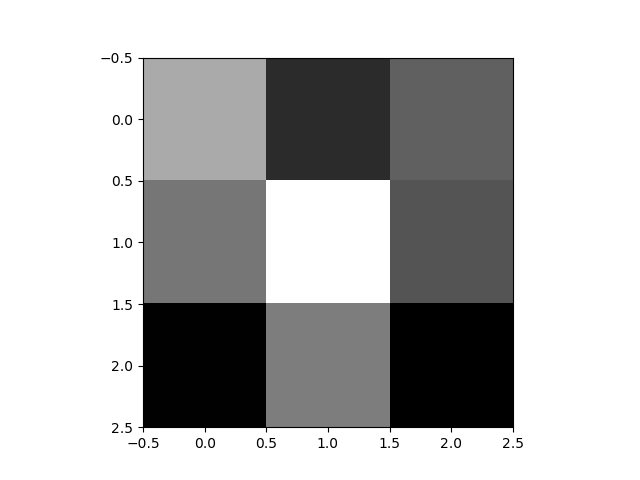

In [31]:
plt.imshow(filters[:,:,0,40], cmap='binary')

## First experiment: fully connected autoencoder

In [ ]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [ ]:
flat_input_ph = tf.placeholder("float", [None, 8 * 8 * 6])
fc_autoencoder1 = create_fully_connected(flat_input_ph, [60, 30, 20], sess)

In [ ]:
# writer = tf.summary.FileWriter('./logs/', graph=tf.get_default_graph())

In [ ]:
train(fc_autoencoder1, X_train, True, flat_input_ph, sess, num_iters=2000)

In [ ]:
decodedLong = sess.run(fc_autoencoder1['decoded'], feed_dict={flat_input_ph: np.reshape(X_eval, (X_eval.shape[0], -1))})

decoded = np.reshape(decodedLong, (X_eval.shape[0], 8, 8, 6))

In [ ]:
np.sum(quantize_arr_vec(decoded) != X_eval) / decoded.size

In [ ]:
arr_to_board(decoded[40])
arr_to_board(X_eval[40])

## Overfit on a tiny training set

In [ ]:
small_inds = np.random.choice(X.shape[0], 10)
X_small = X[small_inds]

In [ ]:
flat_input_ph = tf.placeholder("float", [None, 8 * 8 * 6])
# conv_ae = create_cae(input_ph, [], 400)
fc_autoencoder1 = create_fully_connected(flat_input_ph, [60, 30, 20], sess)

In [ ]:
train(fc_autoencoder1, X_small, True, flat_input_ph, sess, num_iters=10000, lr=.001, batch_size=10)

In [ ]:
arr_to_board(X_small[0])
arr_to_board(np.reshape(sess.run(fc_autoencoder1['decoded'],
                                 feed_dict={flat_input_ph: np.reshape(X_small, (1, -1))})[0], (8, 8, 6)))

## Now a simple conv net

In [ ]:
input_ph = tf.placeholder("float", [None, 8, 8, 6])
conv_ae = create_cae(input_ph, [50, 50, 'pool', 50], 40)

In [ ]:
train(conv_ae, X_train, False, input_ph, sess, num_iters=10000, lr=.001)

In [ ]:
decoded = sess.run(conv_ae['decoded'], feed_dict={input_ph: X_eval})

In [ ]:
np.sum(quantize_arr_vec(decoded) != X_eval) / decoded.size

In [ ]:
arr_to_board(X_eval[52])
arr_to_board(decoded[52])

In [ ]:
train_decoded = sess.run(conv_ae['decoded'], feed_dict={input_ph: X_train})

In [ ]:
np.sum(train_decoded > .5)

In [ ]:
np.sum(X_train > .5)

In [ ]:
np.sum(decoded > .5)

# Come back to this later

In [ ]:
neuron = autoencoder['encoded'][0][5]
neuron_grad = tf.gradients(neuron, x)

# board = np.zeros((8,8,6))
board = np.random.normal(size=(8,8,6), scale=.1)
print(sess.run(neuron, feed_dict={x: np.reshape(board, (1, -1))}))

for i in range(10000):
    grad = sess.run(neuron_grad, feed_dict={x: np.reshape(board, (1, -1))})[0]
    grad = np.reshape(grad, (8,8,6))
    board += 1e-3 * grad
    board[board > 1] = 1
    board[board < -1] = -1
    
    if i % 1000 == 0:
        print(sess.run(neuron, feed_dict={x: np.reshape(board, (1, -1))}))

In [ ]:
arr_to_board(board)

In [ ]:
board